### THIS WORKS WITH OLD CODE, FOR NOW LEAVE IT AS REFERENCE

In [2]:
%load_ext autoreload
%autoreload 2

In [196]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from collections import OrderedDict
from torch.utils.data import TensorDataset, DataLoader, random_split
from networks import *
from dropout import *
from utils import get_dist, eval_error, get_dist_deup, evaluate_and_plot
# from masks import ModelVanillaDropout, ReDropout, ModelWithDropout, ModelWithFixedDropout, CustomDropout, DifferentiableBernoulli, ModelVanillaDropout2

In [29]:
device = torch.device("cpu")
dim = 1
dtype = torch.double
def oracle(x, noise=0):
    # returns sin(2pi x) + epsilon with epsilon ~ N(0, 0.1)
    with torch.no_grad():
        m = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1]))
        m = m.sample((x.size(0),))
    return torch.where(torch.logical_and(x > 0.5, x < 1.5),
                       3./5 * (torch.sin(x) * torch.cos(5 * x) * torch.cos(22 * x) * -3 * torch.sin(7 * x) * torch.cos(19 * x) * 4 * torch.sin(11 * x)),
                       (2 * np.pi * x).sin()) + noise * m

x_test = torch.linspace(-0.5, 2.5, 1024).view(-1, 1).to(dtype)
y_test = oracle(x_test, noise=0).to(dtype)

def generate_data(n=128, nood=24):
    # generate data from U([0, 1/2] union U([1/2 + sep, 1 + sep]))
    # sep needs to be < 1.5
    with torch.no_grad():
        x = torch.zeros(n // 2, 1).uniform_(0, 0.5).to(dtype)
        x = torch.cat((x, torch.zeros(n // 2, 1).uniform_(1.5, 2)), 0).to(dtype)
        y = oracle(x).to(dtype)

        oos_x = torch.zeros(nood // 2, 1).uniform_(-0.5, 0.0).to(dtype)
        oos_x = torch.cat((oos_x, torch.zeros(nood // 2, 1).uniform_(2, 2.5)), 0).to(dtype)
        oos_y = oracle(oos_x).to(dtype)
        split1, split2 = random_split(TensorDataset(oos_x, oos_y), (nood // 2, nood // 2))
        oos_x, oos_y = split1[:]
        oos_x_test, oos_y_test = split2[:]
        
        
        ood_x = torch.zeros(nood, 1).uniform_(0.5, 1.5).to(dtype)
        ood_y = oracle(ood_x).to(dtype)
        split1, split2 = random_split(TensorDataset(ood_x, ood_y), (nood // 2, nood // 2))
        ood_x, ood_y = split1[:]
        ood_x_test, ood_y_test = split2[:]

        return x, y, oos_x, oos_y, ood_x, ood_y, oos_x_test, oos_y_test, ood_x_test, ood_y_test

x, y, oos_x, oos_y, ood_x, ood_y, oos_x_test, oos_y_test, ood_x_test, ood_y_test = generate_data(256, 24)

full_X = torch.cat((x, ood_x, oos_x))
full_Y= torch.cat((y, ood_y, oos_y))
full_data = TensorDataset(full_X, full_Y)

test_data = TensorDataset(torch.cat((ood_x_test, oos_x_test)), torch.cat((ood_y_test, oos_y_test)))
oos_ood = torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y))

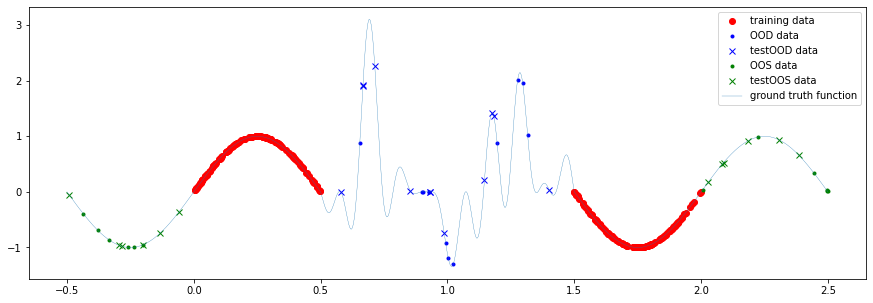

In [30]:
plt.figure(figsize = (15, 5))

plt.plot(x, y.squeeze(), 'ro', label='training data')

plt.plot(ood_x, ood_y.squeeze(), 'b.', label='OOD data')
plt.plot(ood_x_test, ood_y_test.squeeze(), 'bx', label='testOOD data')

plt.plot(oos_x, oos_y.squeeze(), 'g.', label='OOS data')
plt.plot(oos_x_test, oos_y_test.squeeze(), 'gx', label='testOOS data')

plt.plot(x_test, y_test.squeeze(), label='ground truth function', linewidth=.3)
plt.legend()
plt.show()

## Multiplicative Noise Dropout, fixed

In [31]:
def inv_sigmoid(p):
    return np.log(p / (1 - p))

In [203]:
epochs = 500
lr = 1e-3
batch_size = 32
n_hidden = 32

# USE ONE OF THE FOLLOWING BLOCK

#p = [torch.tensor(inv_sigmoid(.3), requires_grad=True), torch.tensor(inv_sigmoid(.3), requires_grad=True)]
#model = ModelWithLearnedDropout(dropout_module=LearnedMultiplicativeGaussianPerLayer, logsigma=[0, 0]).to(dtype)

p = [torch.tensor(inv_sigmoid(.3), requires_grad=True), torch.tensor(inv_sigmoid(.3), requires_grad=True)]
model = ModelWithLearnedSharedDropout(dropout_module=LearnedMultiplicativeGaussianPerLayer, logsigma=[0, 0]).to(dtype)


optimizer = torch.optim.Adam([p for _, p in filter(lambda x:'dropout' not in x[0], model.named_parameters())], lr=lr)
loss_fn = nn.MSELoss()

In [204]:
[x[0] for x in list(model.named_parameters())]

['model.input_layer.weight',
 'model.input_layer.bias',
 'model.dropout1.first.weight',
 'model.dropout1.second.weight',
 'model.dropout1.out.weight',
 'model.hidden_layer1.weight',
 'model.hidden_layer1.bias',
 'model.dropout2.first.weight',
 'model.dropout2.second.weight',
 'model.dropout2.out.weight',
 'model.output_layer.weight',
 'model.output_layer.bias',
 'dropout_shared_mat.weight']

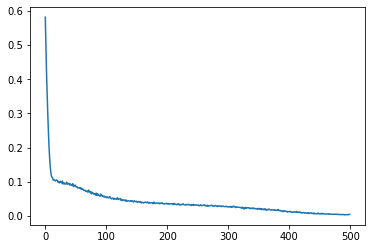

In [206]:
model.train()
train_data = TensorDataset(x, y)
# loader = DataLoader(full_data, shuffle=True, batch_size=batch_size)
loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
losses = []
for epoch in range(epochs):
    # print(torch.sigmoid(model.model.dropout1.p).mean().item(), torch.sigmoid(model.model.dropout2.p).mean().item())
    # print(torch.exp(model.model.dropout1.logsigma).item())
    epoch_losses = []
    for batch_id, (xi, yi) in enumerate(loader):
        optimizer.zero_grad()
        y_hat = model(xi)
        f_loss = loss_fn(y_hat, yi)
        epoch_losses.append(f_loss.item())
        f_loss.backward()
        optimizer.step()
    losses.append(np.mean(epoch_losses))
plt.plot(losses)
plt.show()

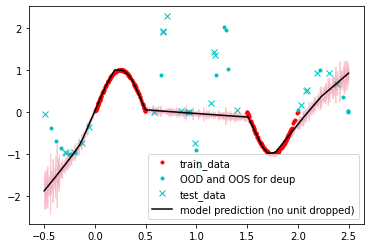

error on train data for deup (before training): 0.17667220765686145 0.001198026534353248
error on test data for deup (before training): 3.0024584566102757 0.02232021447886382
error on train data for deup excluding train (before training): 2.0608576801553418 0.01228771981606759


In [207]:
evaluate_and_plot(model, x_test, x, y, oos_ood, test_data, deup=True)

samples = [eval_error(model, full_X, full_Y).item() for _ in range(100)]
print('error on train data for deup (before training):', np.mean(samples), np.std(samples))
samples = [eval_error(model, test_data[:][0], test_data[:][1]).item() for _ in range(100)]
print('error on test data for deup (before training):', np.mean(samples), np.std(samples))
samples = [eval_error(model, torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y))).item()
           for _ in range(100)]
print('error on train data for deup excluding train (before training):', np.mean(samples), np.std(samples))


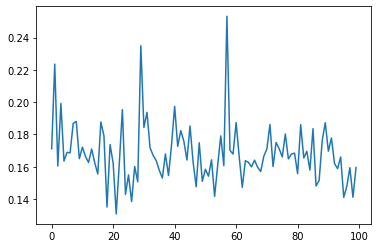

In [208]:
# let's deupify this
# when on eval mode, the mean model prediction shouldn't change

loss_fn = nn.MSELoss()
lr = 1e-3
epochs = 100
batch_size = 32

## !!! choose the parameters wisely here
optimizer = torch.optim.AdamW([p for _, p in filter(lambda x:'dropout' in x[0], model.named_parameters())], lr=lr, weight_decay=0.05)

loader = DataLoader(full_data, shuffle=True, batch_size=batch_size)
losses = []

for epoch in range(epochs):
    # print(torch.sigmoid(model.model.dropout1.p).mean().item(), torch.sigmoid(model.model.dropout2.p).mean().item())
    # print(torch.exp(model.model.dropout1.logsigma))
    epoch_losses = []
    for batch_id, (xi, yi) in enumerate(loader):
        optimizer.zero_grad()
        model.eval()
        y_mean = model(xi)
        model.train()
        y_noisy = model(xi)
        pred_uncertainty = (y_mean - y_noisy) ** 2
        
#         y_noisy = torch.cat([model(xi) for _ in range(10)], 1)
#         pred_uncertainty = y_noisy.var(dim=1).squeeze()

        true_uncertainty = (yi - y_mean) ** 2
        f_loss = loss_fn(pred_uncertainty, true_uncertainty)
        epoch_losses.append(f_loss.item())
        f_loss.backward()
        optimizer.step()
    losses.append(np.mean(epoch_losses))
plt.plot(losses)
plt.show()

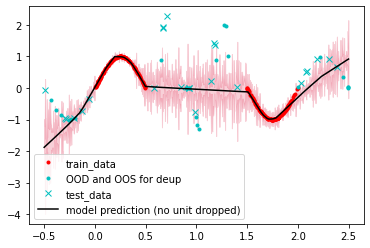

error on train data for deup (before training): 0.16983921223077167 0.015527865749680058
error on test data for deup (before training): 2.700720632660574 0.18927019972901468
error on train data for deup excluding train (before training): 1.8102215705176965 0.16492826134061364


In [209]:
evaluate_and_plot(model, x_test, x, y, oos_ood, test_data, deup=True)

samples = [eval_error(model, full_X, full_Y).item() for _ in range(100)]
print('error on train data for deup (before training):', np.mean(samples), np.std(samples))
samples = [eval_error(model, test_data[:][0], test_data[:][1]).item() for _ in range(100)]
print('error on test data for deup (before training):', np.mean(samples), np.std(samples))
samples = [eval_error(model, torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y))).item()
           for _ in range(100)]
print('error on train data for deup excluding train (before training):', np.mean(samples), np.std(samples))
